In [1]:
import sys

from datasets import DatasetTrain, DatasetVal # (this needs to be imported before torch, because cv2 needs to be imported before torch for some reason)

sys.path.append("/root/deeplabv3/model")
from model.deeplabv3 import DeepLabV3

sys.path.append("/root/deeplabv3/utils")

In [2]:
from utils.utils import add_weight_decay

import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2

############## import ipex ###############
import intel_extension_for_pytorch as ipex
##########################################

import time

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [3]:
model_id = "1"

num_epochs = 200
batch_size = 3
learning_rate = 0.0001

network = DeepLabV3(model_id, project_dir="/root/autodl-tmp/deeplabv3")

network.load_state_dict(torch.load("/root/autodl-tmp/deeplabv3/training_logs/model_1/checkpoints/model_1_epoch_200.pth", map_location=torch.device('cpu')))##

train_dataset = DatasetTrain(cityscapes_data_path="/root/autodl-tmp/deeplabv3/data/cityscapes",
                            cityscapes_meta_path="/root/autodl-tmp/deeplabv3/data/cityscapes/meta")
val_dataset = DatasetVal(cityscapes_data_path="/root/autodl-tmp/deeplabv3/data/cityscapes",
                        cityscapes_meta_path="/root/autodl-tmp/deeplabv3/data/cityscapes/meta")

num_train_batches = int(len(train_dataset)/batch_size)
num_val_batches = int(len(val_dataset)/batch_size)
print ("num_train_batches:", num_train_batches)
print ("num_val_batches:", num_val_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=1)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=batch_size, shuffle=False,
                                        num_workers=1)

pretrained resnet, 18
num_train_batches: 991
num_val_batches: 166


In [4]:
params = add_weight_decay(network, l2_value=0.0001)
optimizer = torch.optim.Adam(params, lr=learning_rate)

############## TorchScript ###############
#optimizer = torch.optim.Adam(params = network.parameters(), lr=0.003)
network.train()
network = ipex.optimize(model = network, optimizer = optimizer)
#network = torch.compile(network, backend="ipex")
##########################################

with open("/root/autodl-tmp/deeplabv3/data/cityscapes/meta/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor))#.cuda()

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

###########################
######## NEW EPOCH ########
###########################
epoch: 201/400
train losses: 0.562156
val losses: 0.545733
###########################
######## NEW EPOCH ########
###########################
epoch: 202/400
train losses: 0.539027
val losses: 0.546624
###########################
######## NEW EPOCH ########
###########################
epoch: 203/400
train losses: 0.518698
val losses: 0.528499
###########################
######## NEW EPOCH ########
###########################
epoch: 204/400
train losses: 0.538117
val losses: 0.543902
###########################
######## NEW EPOCH ########
###########################
epoch: 205/400
train losses: 0.552638
val losses: 0.53728
###########################
######## NEW EPOCH ########
###########################
epoch: 206/400
train losses: 0.527375
val losses: 0.540582
###########################
######## NEW EPOCH ########
###########################
epoch: 207/400
train losses: 0.562975
val losses: 0.549104


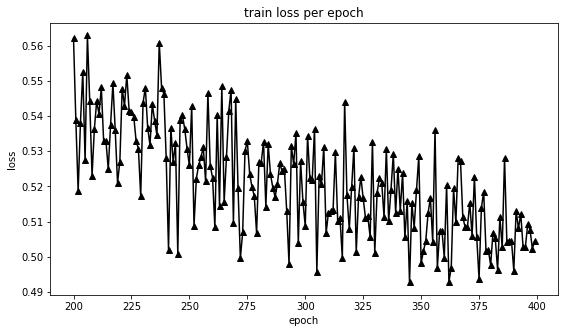

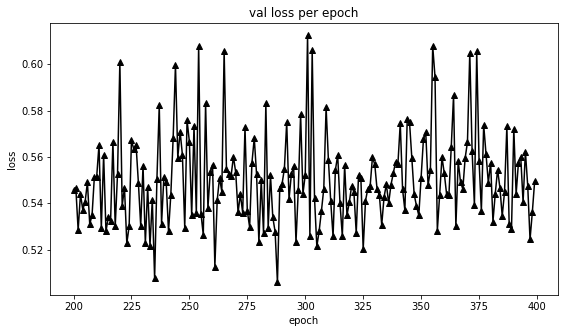

####


In [5]:
epoch_losses_train = []
epoch_losses_val = []
for epoch in range(num_epochs):
    epoch += 200
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    ############################################################################
    # train:
    ############################################################################
    network.train() # (set in training mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs) in enumerate(train_loader):
        #current_time = time.time()

        imgs = Variable(imgs)#.cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor))#.cuda() # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

        #print (time.time() - current_time)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss)
    with open("%s/epoch_losses_train.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_train, file)
    print ("train loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_train, "k^")
    plt.plot(epoch_losses_train, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("train loss per epoch")
    plt.savefig("%s/epoch_losses_train__.png" % network.model_dir)#
    plt.close(1)

    print ("####")

    ############################################################################
    # val:
    ############################################################################
    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs = Variable(imgs)#.cuda() # (shape: (batch_size, 3, img_h, img_w))
            label_imgs = Variable(label_imgs.type(torch.LongTensor))#.cuda() # (shape: (batch_size, img_h, img_w))

            outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

            # compute the loss:
            loss = loss_fn(outputs, label_imgs)
            loss_value = loss.data.cpu().numpy()
            batch_losses.append(loss_value)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss)
    with open("%s/epoch_losses_val.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_val, file)
    print ("val loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_val, "k^")
    plt.plot(epoch_losses_val, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("val loss per epoch")
    plt.savefig("%s/epoch_losses_val__.png" % network.model_dir)#
    plt.close(1)

    # save the model weights to disk:
    checkpoint_path = network.checkpoints_dir + "/model_" + model_id +"_epoch_" + str(epoch+1) + ".pth"
    torch.save(network.state_dict(), checkpoint_path)

In [ ]:
import pickle
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
epoch_losses_train = []
epoch_losses_val = []
x=[]
with open('/root/autodl-tmp/deeplabv3/training_logs/model_1/epoch_losses_train.pkl', 'rb') as file:
    epoch_losses_train = pickle.load(file)
with open('/root/autodl-tmp/deeplabv3/training_logs/model_1/epoch_losses_val.pkl', 'rb') as file:
    epoch_losses_val = pickle.load(file)

plt.figure(figsize=(20, 5)) 
plt.subplot(1, 2, 1) 
plt.plot(x,epoch_losses_train, "k^")
plt.plot(x,epoch_losses_train, "k")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("train loss per epoch")
plt.show()

plt.figure(figsize=(20, 5)) 
plt.subplot(1, 2, 2)
plt.plot(x,epoch_losses_val, "k^")
plt.plot(x,epoch_losses_val, "k")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("val loss per epoch")
plt.show()